In [ ]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


As a first test, this first LDA algorithm was written. As data input, it takes simply a dataframe of the following data pair as row : the reddit's comment text + the id of the post on which the comment was written. The idea was to only give a selected (column wise) and possibly filtered version of the comments from reddit, and the function would make all the necessary in order to model topic on posts. Although nice for the user side, it proved later to be unoptimal for cluster broadcasting.

In [66]:
start_date = datetime.date(year=2016, month=10, day=30)
end_date = datetime.date(year=2016, month=11, day=7)

oct_2016_news_comments = comments.select('link_id','body','created', 'subreddit').filter(comments.created > start_date).filter(comments.created < end_date).filter(comments.subreddit == 'news')

def lda_on_comments(dataset, words_per_topic, n_topics, parser=English(), stop_words=en_stop):
    '''   
    This function performs a LDA (Latent Dirichlet Allocation) model on a set of reddit comments.
    Useful for topic modelling/extraction from a reddit post.
    Parameters
    −−−−−−−−−−
    dataset: pyspark RDD or Dataframe, schema should have only three data type : 
              the post id (link_id), the body of the comment and the creation date in this order.
              
    words_per_topic: number of words that should constitute a topic per post.
    
    n_topics: number of topics to extract by post
    
    parser: the natural language parser used, corresponds to a language normally,
            by default english (as it is the most used language on reddit).
            should be a parser from the spacy.lang library.
    
    stop_words: set of words that constitutes stop words (i.e. that should be
                removed from the tokens)

    Returns
    −−−−−−−
    A RDD with the following pair of data as rows : (<post_id>, <topic (as a list of words)>)) 
    '''
    #useful functions for preprocessing the data for LDA
    def tokenize(text):
        lda_tokens = []
        tokens = parser(text)
        for token in tokens:
            if token.orth_.isspace():
                continue
            elif token.like_url:
                lda_tokens.append('URL')
            elif token.orth_.startswith('@'):
                lda_tokens.append('SCREEN_NAME')
            else:
                lda_tokens.append(token.lower_)
        return lda_tokens

    def get_lemma(word):
        lemma = wn.morphy(word)
        if lemma is None:
            return word
        else:
            return lemma

    def get_lemma2(word):
        return WordNetLemmatizer().lemmatize(word)

    def prepare_text_for_lda(text):
        tokens = tokenize(text)
        tokens = [token for token in tokens if len(token) > 4]
        tokens = [token for token in tokens if token not in en_stop]
        tokens = [get_lemma(token) for token in tokens]
        return tokens
    
    def get_n_topics(text_data):
        dictionary = gensim.corpora.Dictionary(text_data)
        corpus = [dictionary.doc2bow(text) for text in text_data]
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = n_topics, id2word=dictionary, passes=15)
        topics = ldamodel.print_topics(num_words=words_per_topic)
        return topics
    
    def extract_key_words(lda_result):
        return re.findall(r'\"(.*?)\"', lda_result)

    #detecting type of the input given.
    if isinstance(dataset, pyspark.sql.dataframe.DataFrame):
        dataset = dataset.rdd
    elif not isinstance(dataset, pyspark.rdd.RDD):
        raise ValueError('Wrong type of dataset, must be either a pyspark RDD or pyspark DataFrame')
    
    #TODO : keep the minimum timestamp (r[2] of the dataset) during computations.
    
    #filtering comments that were removed, to avoid them to pollute the topics extracted
    filter_absent_comm = dataset.filter(lambda r: r[1] != '[removed]' and r[1] != '[deleted]')
    
    #applying text preprocesisng for LDA + filtering all empty sets (without tokens as the result of the LDA preprocessing)
    LDA_preprocessed = filter_absent_comm.map(lambda r: (r[0], list(prepare_text_for_lda(r[1])))).filter(lambda r: r[1])
    
    #groupy every comments by post/thread id.
    post_and_list_token = LDA_preprocessed.groupByKey().map(lambda x : (x[0], list(x[1])))
    
    #generating n topics per post/thread.
    res_lda = post_and_list_token.map(lambda r: (r[0],get_n_topics(r[1]))).flatMap(lambda r: [(r[0], t) for t in r[1]])
    
    return res_lda.map(lambda r: (r[0], ' '.join(extract_key_words(r[1][1])))).toDF().selectExpr("_1 as post_id", "_2 as topic")

res = lda_on_comments(oct_2016_news_comments.rdd.map(lambda r: r), 2, 1)
#hillary_and_trump = res.filter(lambda r: ('trump' in r[1]) or ('hillary' in r[1]) or ('donald' in r[1]) or ('clinton' in r[1]))
res.show()

+---------+--------------------+
|  post_id|               topic|
+---------+--------------------+
|t3_5axjwf|already:/ pennsyl...|
|t3_5aw066|        excuse least|
|t3_5as8g0|    amendment civics|
|t3_5aiyva|       school people|
|t3_5ap0a7|     military payday|
|t3_5apdai|              thanks|
|t3_5b5m2v|      people picture|
|t3_5b3jm9|       dealer option|
|t3_5acf8u|       police arrest|
|t3_5a61rd|       bones chicken|
|t3_5ah1kd|    people insurance|
|t3_5aih4r|        drug looking|
|t3_5b6w4x|      complain going|
|t3_5akrra|     another appoint|
|t3_5b9ik4|       money private|
|t3_5abvof|     believing great|
|t3_5bbo5w|      murderer extra|
|t3_5aqikp|         replacement|
|t3_5b7a5q|       humor officer|
|t3_5b201j|        larger force|
+---------+--------------------+
only showing top 20 rows



## Concatenating all comments from one post previous to performing LDA 

As the basic LDA algorithm written previously using gensim and spacy cannot be broadcasted easily to the cluster due to heavy libraries dependencies, I produced this rewritten version, which assumes the dataset given as input is already a combined by post pastiche of comments from reddit (done by condense_post_into_text). Thus, it leaves to lda_on_posts the sole duty of performing the LDA.

The condense post_into_text part is purely pyspark manipulations, thus it could be broadcasted to the cluster. While waiting for a full cluster version of LDA, condense_post_into_text could be used with some subreddit and time-window filtering in order to produce a parquet of post text with timestamp that could be processed locally using the lda_on_posts function.

Splitting the pyspark and lda part of the previous algorithm also allowed me to have a better way to compute the timestamp of the post, which is useful to model a trend.

In [94]:
def condense_post_into_text(dataset):
    '''
    Funciton whose purpose is to condensate all comments
    of one post (identified by lind_id) into on array
    '''
    
    #keeping only what matters
    dataset = dataset.select('link_id', 'body', 'created')

    zeroValue = (list(), datetime.date(year=3016, month=12, day=30))
    
    combFun = lambda l, r: (l[0] + r[0], min(l[1], r[1]))

    seqFun = lambda prev, curr: (prev[0] + [curr[0]], prev[1] if prev[1] < curr[1] else curr[1])
    
    #removing post that have been deleted/removed (thus hold no more information)
    filtered = dataset.filter(dataset.body != '[removed]').filter(dataset.body != '[deleted]').filter(dataset.body != '')

    post_and_list_token = filtered.rdd.map(lambda r: (r[0], (r[1], r[2]))).aggregateByKey(zeroValue, seqFun, combFun)
    
    return post_and_list_token.map(lambda r: (r[0], r[1][0], r[1][1])).toDF().selectExpr("_1 as post_id", "_2 as text","_3 as created")


def lda_on_posts(dataset, n_topics, n_words):
    #The post entry in the df/rdd is an id, followed by a disordered list of 
    def tokenize(text):
        lda_tokens = []
        tokens = parser(text)
        for token in tokens:
            if token.orth_.isspace():
                continue
            elif token.like_url:
                lda_tokens.append('URL')
            elif token.orth_.startswith('@'):
                lda_tokens.append('SCREEN_NAME')
            else:
                lda_tokens.append(token.lower_)
        return lda_tokens

    def get_lemma(word):
        lemma = wn.morphy(word)
        if lemma is None:
            return word
        else:
            return lemma

    def get_lemma2(word):
        return WordNetLemmatizer().lemmatize(word)

    def prepare_text_for_lda(text):
        tokens = tokenize(text)
        tokens = [token for token in tokens if len(token) > 4]
        tokens = [token for token in tokens if token not in en_stop]
        tokens = [get_lemma(token) for token in tokens]
        return tokens

    def get_n_topics(text_data):
        dictionary = gensim.corpora.Dictionary(text_data)
        
        corpus = [dictionary.doc2bow(text) for text in text_data]
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = n_topics, id2word=dictionary, passes=15)
        topics = ldamodel.print_topics(num_words=n_words)
        return topics

    def extract_key_words(lda_result):
        return re.findall(r'\"(.*?)\"', lda_result)
    
    #applying text preprocesisng for LDA + filtering all empty sets (without tokens as the result of the LDA preprocessing)
    preprocessed = dataset.rdd.map(lambda r: (r[0], [prepare_text_for_lda(comm) for comm in r[1]], r[2]))
    
    #this may seem a bit unnecesseray, but it prevents rare posts whose text has been cleansed by stop-words.
    preprocessed_filtered = preprocessed.filter(lambda r: r[1]).filter(lambda r: r[1][0])
    
    #generating n topics per post/thread.
    res = preprocessed_filtered.map(lambda r: (r[0],get_n_topics(r[1]), r[2])).flatMap(lambda r: [(r[0], t, r[2]) for t in r[1]])
    
    return res.map(lambda r: (r[0], ' '.join(extract_key_words(r[1][1])), r[2])).toDF().selectExpr("_1 as post_id", "_2 as topic", "_3 as created")



### Trend Analysis using 1 topic by post, and 1 word per topic

Let's try the LDA on all comments from the subreddit "news" during the month preceding the 2016 US presidential election. The most simplest and general topic modelling that can be done, is asking the LDA to produce only one topic consisting of 1 word per post.

In [198]:
lda_result_one_w_df = spark.read.load('../data/oneW_oneT_lda_result.parquet').toPandas().set_index('post_id')

In [199]:
frequency_df = lda_result_one_w_df['topic'].value_counts()
frequency_df.head(20)

people      394
would       135
police       77
article      50
school       41
child        39
trump        38
woman        35
clown        33
pipeline     33
could        29
state        28
attack       26
actually     25
black        25
phone        24
right        24
american     23
officer      22
russia       22
Name: topic, dtype: int64

With only one topic limited to one word, we obviously generalize a bit too much the topic of the discussion and get very broad subject such as "people" as the most frequent topic. Of course, most of the discussion of news might be based on people, so it is not really a surprise. However the word "trump" is the fifth most frequent topic during this timeframe, which come as no surprise, as it was the month before the election, but it is good news for our research, as it shows that trump was indeed a topic of interest in news the month before the election. 
The election rival of Donald Trump, Hillary Clinton, 

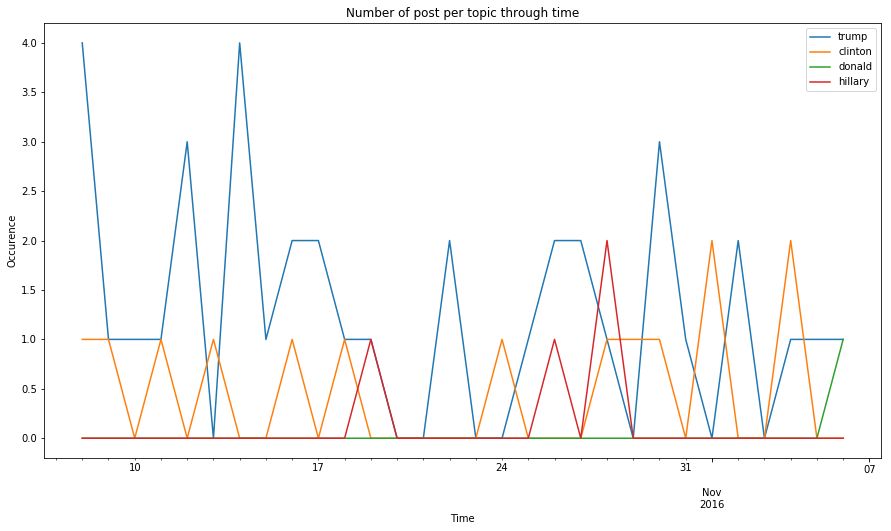

In [209]:
import pandas as pd

topics = ['trump', 'clinton', 'donald', 'hillary']

def plot_frequency_of_topics(dataset, topics):
    current_df = dataset
    idx = pd.period_range(min(current_df.created), max(current_df.created)).to_series()
    ts_df = pd.DataFrame({'created': list(idx), 'dummy': [0 for i in range(len(idx))]}).set_index('created')
    ts_df.index = ts_df.index.to_timestamp()

    for t in topics:
        topic_df = lda_result_one_w_df[lda_result_one_w_df.topic == t][['created', 'topic']]
        toplot = topic_df.groupby(['created']).agg(len).rename({'topic':t}, axis=1)
        ts_df = ts_df.join(toplot, how='left')

    ts_df = ts_df.drop(columns='dummy').fillna(0)
    ax = ts_df.plot(title='Number of post per topic through time', figsize=(15,8))
    ax.set_xlabel('Time')
    ax.set_ylabel('Occurence')
    
plot_frequency_of_topics(lda_result_one_w_df, topics)

### Trend Analysis using 2 topic by post, and 3 word per topic

An advantage of LDA, is its ability to extract any number of topic 

In [200]:
lda_result_df = spark.read.load('../data/threeW_twoT_lda_result.parquet').toPandas().set_index('post_id')

In [201]:
lda_result_df['topic'].value_counts().head(20)

people would think         10
people black white          8
right                       6
pretty                      4
police people would         4
people would money          4
alive                       4
video                       4
people black police         4
people think would          4
people would government     3
would people police         3
people right would          3
insurance people health     3
insurance people would      3
pipeline would people       3
would people think          3
people driving think        3
people white black          3
police would officer        3
Name: topic, dtype: int64

In [104]:
LDA_result.write.mode('overwrite').parquet('threeW_twoT_lda_result.parquet')